In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import seaborn as sns
import io #Used as buffer

In [17]:
nn_p=5
nn_w = 5
nn_tw = 1
m = 'sr'
freq = 5

In [18]:
df = get_data(m)

In [19]:
df = df[(df['nnw']==str(nn_w))&(df['nntw']==str(nn_tw))&(df['nnp']==str(nn_p))|(df['isnn']==False)]

In [20]:
df_pivot = get_heatmap_data('sr',df)[labels_order]
df_pivot=df_pivot.query(f'freq=={freq} or freq==10')
#df_pivot_rank = df_pivot.rank(axis=1, ascending=False)
df_pivot = df_pivot.reset_index()
df_pivot.experiment = df_pivot.experiment.str.slice(3)
df_pivot.set_index(['experiment','function','freq'], inplace=True)

In [21]:
df_pivot.style.background_gradient(cmap=plt.cm.Greens, axis=1)

In [22]:
summary = df_pivot.groupby(['experiment','function']).mean() #

summary.round(2).style.background_gradient(cmap=plt.cm.Greens, axis=1)

In [23]:
summary.round(2).style.highlight_max(axis=1)

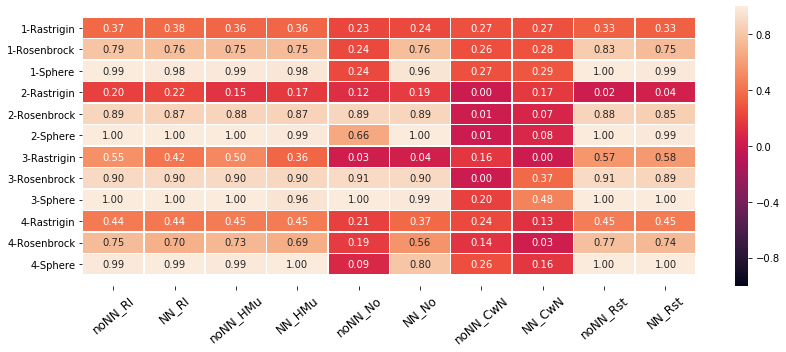

In [24]:
fig,ax = plt.subplots(figsize=(12,5))
sns.heatmap(summary, annot=True, linewidths=.5, ax=ax, cmap=sns.cm.rocket, vmin=-1, fmt='.2f',)
u,l = ax.get_ylim()
ax.set_ylim(u+0.5, l-0.5)
ax.set_ylabel('')
ax.set_xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_rotation(40)
    
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(10)
plt.tight_layout()
fig.savefig(PATH_RESULTS/'heatmapSR.eps', dpi=400, format='eps')